In [1]:
import os
from learning.normaleqs import N_TIME, get_clean_data,pick_time_index
from learning.genetic import gen_sol_location
import numpy as np
import dask.distributed
import xgboost as xgb
import sys

In [2]:
cluster = dask.distributed.LocalCluster()
client = dask.distributed.Client(cluster)
params = {
    "objective": "reg:squarederror",
}

In [3]:
df =  get_clean_data()

In [4]:
time_index = 1
y_index = 0 

In [5]:
from learning.xgbhyper import get_nnz_feats


df = pick_time_index(df,time_index)
ycols = ['Y1','Y2']
# inds = get_nnz_feats(time_index,y_index)
xcols = np.array([c for c in df.columns if c not in ycols])
# xcols = xcols[inds]
ycol = [ycols[y_index]]
xinds = [df.columns.tolist().index(c) for c in xcols]
yinds = [df.columns.tolist().index(c) for c in ycol]
print(f'converting to dask_array',flush =True)
df_arr = df.to_dask_array(lengths = True)

x_arr = df_arr[:,xinds]
y_arr = df_arr[:,yinds]

inds = np.arange(df_arr.shape[0])

converting to dask_array


/Users/cemgultekin/Documents/clear-street-markets/.env/lib/python3.9/site-packages/dask/core.py:127: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return func(*(_execute_task(a, cache) for a in args))
/Users/cemgultekin/Documents/clear-street-markets/.env/lib/python3.9/site-packages/dask/core.py:127: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return func(*(_execute_task(a, cache) for a in args))
/Users/cemgultekin/Documents/clear-street-markets/.env/lib/python3.9/site-packages/dask/core.py:127: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return func(*(_execute_task(a, cache) for a in args))
/Users/cemgultekin/Documents/clear-street-markets/.env/lib/python3.9/site-packages/dask/core.py:127: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return func(*(_execute_task(a, cache) for a in args))
/Users/cemgultekin/Documents/clear-street-markets/.env/lib/python3.9

In [6]:
n_cv = 2
x_arr = df_arr[:,xinds]
y_arr = df_arr[:,yinds]

inds = np.arange(df_arr.shape[0])
        
split_indices = np.array_split(inds,n_cv,axis = 0)
cv_indices = []
for i in range(n_cv):
    tr = np.concatenate(split_indices[:i]+split_indices[i+1:])
    ts = split_indices[i]
    cv_indices.append((tr,ts))

In [7]:
ddmats = []

sc2 = []
for i,(tr,ts) in enumerate(cv_indices):
    print(f'forming DaskDMatrix for cv #{i}',flush=True)
    trset = xgb.dask.DaskDMatrix(client, x_arr[tr,:],y_arr[tr])
    tsset = xgb.dask.DaskDMatrix(client, x_arr[ts,:],y_arr[ts])
    ddmats.append((trset,tsset))                                
    
    sc2.append(np.mean(y_arr[ts]**2).compute())  

forming DaskDMatrix for cv #0


/Users/cemgultekin/Documents/clear-street-markets/.env/lib/python3.9/site-packages/dask/core.py:127: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return func(*(_execute_task(a, cache) for a in args))
/Users/cemgultekin/Documents/clear-street-markets/.env/lib/python3.9/site-packages/dask/core.py:127: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return func(*(_execute_task(a, cache) for a in args))
/Users/cemgultekin/Documents/clear-street-markets/.env/lib/python3.9/site-packages/dask/core.py:127: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return func(*(_execute_task(a, cache) for a in args))
/Users/cemgultekin/Documents/clear-street-markets/.env/lib/python3.9/site-packages/dask/core.py:127: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return func(*(_execute_task(a, cache) for a in args))
/Users/cemgultekin/Documents/clear-street-markets/.env/lib/python3.9

forming DaskDMatrix for cv #1


/Users/cemgultekin/Documents/clear-street-markets/.env/lib/python3.9/site-packages/dask/core.py:127: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return func(*(_execute_task(a, cache) for a in args))
/Users/cemgultekin/Documents/clear-street-markets/.env/lib/python3.9/site-packages/dask/core.py:127: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return func(*(_execute_task(a, cache) for a in args))
/Users/cemgultekin/Documents/clear-street-markets/.env/lib/python3.9/site-packages/dask/core.py:127: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return func(*(_execute_task(a, cache) for a in args))
/Users/cemgultekin/Documents/clear-street-markets/.env/lib/python3.9/site-packages/dask/core.py:127: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return func(*(_execute_task(a, cache) for a in args))
/Users/cemgultekin/Documents/clear-street-markets/.env/lib/python3.9

In [8]:
np.sqrt(sc2)

array([11.331002,  9.383665], dtype=float32)

In [9]:
from learning.genetic import FitnessFunctor

ti = time_index
yi = y_index
def linear_score(ti,yi):
    ftn = FitnessFunctor(ti,yi,verbose=False)
    loc= gen_sol_location(ti,yi)
    print(f'loaded weights = {loc}')
    w = np.load(loc)
    b = np.abs(w) != 0
    b = np.array(b.tolist() + [-np.inf])
    err,sc2 = ftn.get_err_sc2(b)
    return 1 - np.sum(err)/np.sum(sc2)
print(linear_score(ti,yi))

loaded weights = /Users/cemgultekin/Documents/clear-street-markets/genetic_solutions/t1_y0.npy
0.0035490841414815844


[23:22:20] task [xgboost.dask-0]:tcp://127.0.0.1:60097 got new rank 0
[23:22:20] task [xgboost.dask-1]:tcp://127.0.0.1:60096 got new rank 1
[23:22:20] task [xgboost.dask-2]:tcp://127.0.0.1:60101 got new rank 2
[23:22:20] task [xgboost.dask-3]:tcp://127.0.0.1:60102 got new rank 3
[23:22:20] task [xgboost.dask-4]:tcp://127.0.0.1:60104 got new rank 4


[0]	train-rmse:9.38319	test-rmse:11.33109
[1]	train-rmse:9.38260	test-rmse:11.33129
[2]	train-rmse:9.38205	test-rmse:11.33097
[3]	train-rmse:9.38154	test-rmse:11.33093
[4]	train-rmse:9.38072	test-rmse:11.33075
[5]	train-rmse:9.38041	test-rmse:11.33079
[6]	train-rmse:9.37994	test-rmse:11.33088
[7]	train-rmse:9.37931	test-rmse:11.33068
[8]	train-rmse:9.37876	test-rmse:11.33066
[9]	train-rmse:9.37838	test-rmse:11.33063
[10]	train-rmse:9.37785	test-rmse:11.33060
[11]	train-rmse:9.37742	test-rmse:11.33055
[12]	train-rmse:9.37685	test-rmse:11.33035
[13]	train-rmse:9.37626	test-rmse:11.33011
[14]	train-rmse:9.37569	test-rmse:11.33011
[15]	train-rmse:9.37518	test-rmse:11.33001
[16]	train-rmse:9.37472	test-rmse:11.32976
[17]	train-rmse:9.37410	test-rmse:11.32979
[18]	train-rmse:9.37367	test-rmse:11.32974
[19]	train-rmse:9.37346	test-rmse:11.32965
[20]	train-rmse:9.37299	test-rmse:11.32958
[21]	train-rmse:9.37263	test-rmse:11.32950
[22]	train-rmse:9.37215	test-rmse:11.32949
[23]	train-rmse:9.371

[23:22:39] task [xgboost.dask-0]:tcp://127.0.0.1:60097 got new rank 0
[23:22:39] task [xgboost.dask-1]:tcp://127.0.0.1:60096 got new rank 1
[23:22:39] task [xgboost.dask-2]:tcp://127.0.0.1:60101 got new rank 2
[23:22:39] task [xgboost.dask-3]:tcp://127.0.0.1:60102 got new rank 3
[23:22:39] task [xgboost.dask-4]:tcp://127.0.0.1:60104 got new rank 4


[0]	train-rmse:11.32930	test-rmse:9.38472
[1]	train-rmse:11.32873	test-rmse:9.38462
[2]	train-rmse:11.32807	test-rmse:9.38458
[3]	train-rmse:11.32728	test-rmse:9.38469
[4]	train-rmse:11.32687	test-rmse:9.38458
[5]	train-rmse:11.32650	test-rmse:9.38463
[6]	train-rmse:11.32612	test-rmse:9.38458
[7]	train-rmse:11.32556	test-rmse:9.38462
[8]	train-rmse:11.32502	test-rmse:9.38464
[9]	train-rmse:11.32420	test-rmse:9.38463
[10]	train-rmse:11.32361	test-rmse:9.38472
[11]	train-rmse:11.32316	test-rmse:9.38482
[12]	train-rmse:11.32258	test-rmse:9.38473
[13]	train-rmse:11.32179	test-rmse:9.38494
[14]	train-rmse:11.32126	test-rmse:9.38490
[15]	train-rmse:11.32064	test-rmse:9.38492
[16]	train-rmse:11.32023	test-rmse:9.38480
[17]	train-rmse:11.31953	test-rmse:9.38505
[18]	train-rmse:11.31899	test-rmse:9.38512
[19]	train-rmse:11.31872	test-rmse:9.38512
[20]	train-rmse:11.31781	test-rmse:9.38497
[21]	train-rmse:11.31702	test-rmse:9.38500
[22]	train-rmse:11.31612	test-rmse:9.38519
[23]	train-rmse:11.31

Text(0.5, 1.0, '0.0003273729950614701')

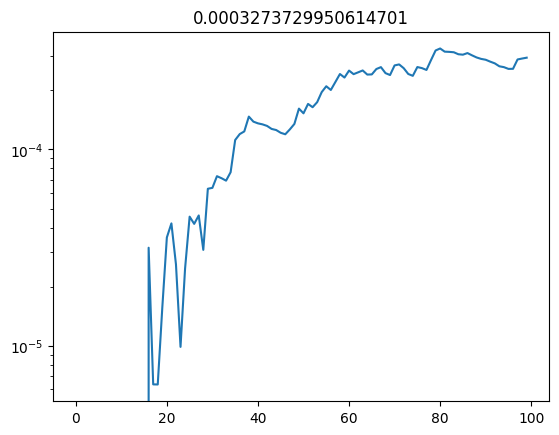

In [14]:
pparam = {
    "eta" : 5e-3,
    "gamma" : 500,
    "max_depth" : 3,
    "min_child_weight" : 100,
    "subsample" : 0.8,
    "colsample_bytree" : 0.2,
    # "alpha" : 10,
    # "booster":"dart",
    # "rate_drop" :0.2,
    # "skip_drop" : 0.5
}
num_boost_round = 100
ts_err = 0
for tr,ts in ddmats:    
    output = xgb.dask.train(client,pparam, tr,evals = ((tr,'train'),(ts,'test')),verbose_eval=True, num_boost_round=num_boost_round)
    ts_err += np.array(output['history']['test']['rmse'])**2
ts_r2 = 1 - ts_err/np.sum(sc2)
import matplotlib.pyplot as plt
plt.semilogy(ts_r2,label = 'test')
plt.title(np.amax(ts_r2))